# infos

In [ ]:
# Version 1.1

# Modèle basé sur les 10 espèces les plus représentées du jeu de données.
# Images triées : Ok

### Changelogs :

v1.1 :
- Nettoyage du code pour livraison projet
- Amélioration du modèle, entrainement sous format v1.1


v1.0 :
- Itération d'un modèle avec les images non triées et triées.
- Les modèles sont enregistrés sous format V1 pour tests ultérieurs

# Definition des URL

In [1]:
# Vérifier que les chemins soient correct avant toutes opérations

# Définition du dossiers contenant les images
chemin_images = '../../images/'

# Définition du fichier .csv utilisé
chemin_csv = '../data/top10.csv'


# Définition du DataFrame echantillon (utile pour tests de modèles car entrainements plus rapides)
pourcentage_echantillon = 0.3 # Ex: 0.1 = 10% du contenu

# Dimensions retenues des images en entrée du modèle
img_dim = (224,224)
img_shape = (224,224,3)

# Google Colab

/!\ Ignorer les cellules qui suivent si le notebook ne tourne pas sur Colab

In [2]:
# Importer les images en format .zip
from google.colab import files
files.upload()

{}

In [2]:
# Monter le Drive si necessaire
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dezipper le fichier images dans Colab
!unzip '/content/drive/MyDrive/SAS/images.zip' -d '/images'

In [3]:
# Remplacer les chemins en corrélation avec les dossiers colab

# Chemin vers le dossier images
chemin_images = '/images/images/'

# Chemin vers le fichier .csv utilisé
chemin_csv = '/content/drive/MyDrive/SAS/Jul23_bds_champignons/data/top10.csv'

# Librairies à charger

In [4]:
# Librairies générales servant dans le notebook
import pandas as pd
import os


# Librairies appelées pour l'utilisatio ndes fonctions définies dans la partie 'fonctions
from tensorflow.keras.applications.efficientnet import preprocess_input


# Librairies utilisées pour les callbacks
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from timeit import default_timer as timer
from tensorflow.keras.callbacks import TerminateOnNaN


# Librairies utilisées pour créer les pipelines et le modèle
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


# Librairies utilisées pour la création des jeux d'entrainement, de test et de validation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter


# Librairies utilisées pour l'évaluation du modèle une fois entrainé
import matplotlib.pyplot as plt
%matplotlib inline

# Fonctions

In [5]:
def import_df(chemin_images, chemin_csv, pourcentage_echantillon):
    '''
    Importe le fichier csv et construit 2 df :
        - Le DF basé sur le CSV original
        - Un DF echantillon comportant 10% de données aléatoires du DF original

    Arguments :
        - chemin_images : Chemoin vers le dossier images
        - chemin_csv : Chemin vers le fichier .csv contenant les données utilisées
        pourcentage_echantillon : Taille du DF echantillon tiré du DF original
    '''


    # import du df
    df = pd.read_csv(chemin_csv, low_memory=False)
    df['image_url'] = df['image_url'].str.replace('.../images/', chemin_images)
    print(f"Nombre d'images chargées pour df: {df.shape[0]}")
    print(f"Nb especes dans df: {df['label'].nunique()}")


    # Contruction de l'echantillon
    L = len(df)
    L_ech = int(pourcentage_echantillon * L)
    df_ech = df.sample(n=L_ech, random_state=10)
    df_ech.reset_index(inplace=True, drop=True)
    print(f"Nombre d'images chargées pour df_ech: {df_ech.shape[0]}")
    print(f"Nb especes dans df_ech: {df_ech['label'].nunique()}")


    return df, df_ech

In [6]:
def augment_img(image_path, label):

   '''
    Modifie les images aléatoirement dans le dataset qui sera soumis au modèle.
      - image_path : URL des images (contenue dans la variable 'image_url' dans le DF chargé),
      - label : Variable contenant les classes
   '''

   # Lecture image, decodage
   img = tf.io.read_file(image_path)
   img = tf.image.decode_png(img, channels=3)

   # Redimensionnement selon dimensions définies en début de notebook (img_dim)
   img = tf.image.resize(img, img_dim)

   # Pre-processing pour transfert learning, modèle efficienNet
   img = preprocess_input(img)

   # Augmentations aléatoires des images :

   # Inversion Gauche/Droite
   img = tf.image.random_flip_left_right(img)

   # Inversion Haut/Bas
   img = tf.image.random_flip_up_down(img)

   # Modification luminosité
   img = tf.image.random_brightness(img, max_delta=0.2)

   # Modification contraste
   img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

   # Conversion du type en float32
   img = tf.image.convert_image_dtype(img, tf.float32)

   # Normalisation
   img = (img - tf.math.reduce_min(img)) / (tf.math.reduce_max(img) - tf.math.reduce_min(img))

   return img, label

In [7]:
def create_tf_dataset(image_path, labels, batch_size):
    '''
    Créé un dataset Tensorflow selon les paramètres précisés.
        - image_path : chemin relatif de la variable contenant les images
        - labels : variable contenant les labels
        - batch_size : taille des batchs
        - oversample_cls : Liste contenant les classes à oversampler. Si non précisé, l'oversample sera ignoré.
    '''

    image_path = image_path.tolist()  # Convertir les chemins d'images en liste
    labels = labels.tolist()          # Convertir les labels en liste



    # Construction du Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    # .map appelle la fonciton d'augmentation d'image définie
    dataset = dataset.map(augment_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Mélange aléatoire du dataset
    dataset = dataset.shuffle(buffer_size=len(image_path))

    # Découpage en batch
    dataset = dataset.batch(batch_size)

    # Optimisation : Charge les données en arrière-plan et maintien la charge CPU/GPU
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [8]:
def controle_presence_fichiers(df, chemin_images):

    '''
    Controle que les fichiers images soient bien présents sur le disque.
        - df : DataFrame contenant les url des fichiers images
        - chemin_images : Variable du DF contenant les url
    '''

    image_directory = chemin_images
    missing_files = []

    # Parcourir chaque ligne du DataFrame
    for index, row in df.iterrows():
        image_path = os.path.join(image_directory, row['image_lien'])

        if not os.path.exists(image_path):
            missing_files.append(image_path)

    # Afficher les fichiers non trouvés
    if missing_files:
        print("\nFichiers non trouvés :")
        for file_path in missing_files:
            print(file_path)

    # Ou préciser que tous les fichiers sont présents
    else:
        print("\nTous les fichiers sont présents.")

# Callbacks

Callback utilisés pour l'entrainement du modèle

### Tensorboard

In [9]:
# Session Tensorboard pour suivi lors de l'entrainement
%load_ext tensorboard
log_dir = '../tensor_board_logs'
tensorboard = callbacks.TensorBoard(log_dir = log_dir)

### EarlyStopping

In [10]:
# earlystopping défini pour réduire le temps d'entrainement si l'accuracy n'évolue plus.
early_stopping = EarlyStopping(monitor = 'accuracy',
                               min_delta = 0.03,
                               patience = 8,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True)

### Reduce LearningRate

In [11]:
# Reduction du learning Rate
reduceLR = ReduceLROnPlateau(monitor = 'val_loss',
                             min_delta = 0.01,
                             patience = 5,
                             factor = 0.15,
                             cooldown = 3,
                             verbose = 1)

### Checkpoint

In [12]:
# Enregistrement du modèle en cas d'amélioration lors de l'entrainement, ne conserve que la meilleure itération
checkpoint = ModelCheckpoint(filepath='../model/checkpoint_model', monitor='accuracy', save_best_only=True, verbose=1)

### Timer

In [13]:
# Suivi du temps d'entrainement
class TimingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs=None):
        endtime = timer()
        elapsed_time = endtime - self.starttime
        self.logs.append(elapsed_time)
        print(f"Epoch {epoch + 1} took {elapsed_time:.2f} seconds")

time_callback = TimingCallback()

### Terminate on NaN

In [14]:
# Temrine l'entrainement en cas de NaN
TON = TerminateOnNaN()

# Construction modèle

### Import du modèle pré-entrainé

In [15]:
# import du modèle efficientNetv2 pré-entrainé depuis Tensorflow Hub, les couches de convolution sont gelées
efficientNetv2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2"
pre_trained_model = hub.KerasLayer(efficientNetv2, input_shape=(224, 224, 3), trainable=False)

### Definition des couches

In [16]:
# Couches de convolution :
reshape_layer = layers.Reshape((1, 1, 1000))  # Cette couche permet d'entrer la sortie du modèle pré-entrainé dans la couche GlobalAveragePooling2D
gap = GlobalAveragePooling2D()

# Couches de regularisation :
dropout = Dropout(0.3)

# Couches dense :
dense = Dense(256, activation='relu', kernel_regularizer=l2(0.01)) # Régularisation L2
output = Dense(units = 10, activation='softmax') # Couche de sortie (10 classes)

### Construction du modèle

In [17]:
def build_model():

    model = tf.keras.Sequential()
    #model = models.Sequential()

    # Modèle pré-entrainé
    model.add(pre_trained_model)

    # Couches supplémentaires pour classification
    model.add(reshape_layer)
    model.add(gap)
    model.add(dropout)
    model.add(dense)

    # Couche de sortie
    model.add(output)  # 10 classes de sortie

    return model

In [18]:
model = build_model()

### Compilation du modèle

In [19]:
# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Afficher un résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              7200312   
                                                                 
 reshape (Reshape)           (None, 1, 1, 1000)        0         
                                                                 
 global_average_pooling2d (  (None, 1000)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

# Pipeline Dataset

### Import des DataFrames

In [21]:
df, df_ech = import_df(chemin_images, chemin_csv, pourcentage_echantillon)

Nombre d'images chargées pour df: 60481
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 18144
Nb especes dans df_ech: 10


<ipython-input-5-7c173ed5f5a6>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_url'] = df['image_url'].str.replace('.../images/', chemin_images)


In [22]:
# Préciser sur quelles données travailler (df_ech est un echantillon permettant de réduire le temps d'entrainement pour effectuer des tests)
# Commenter/Decommenter la ligne souhaitée
#donnees_training = df_ech
donnees_training = df

In [23]:
# Représentation des classes
donnees_training.groupby('label').count()

,image_lien,image_url
label,,
Agaricales,3363,3363
Agaricus,1272,1272
Amanita,1469,1469
Cortinarius,2147,2147
Entoloma,1170,1170
Inocybe,1281,1281
Mycena,1514,1514
Polyporales,1998,1998
Psathyrella,1583,1583


In [24]:
# Controle de la présence des fichiers images
controle_presence_fichiers(donnees_training, chemin_images)

# On supprime ensuite la colonne image_lien qui ne sert qu'à controler la présence des fichiers.
donnees_training.drop('image_lien', axis=1, inplace=True)


Tous les fichiers sont présents.


### Construction des jeux de données (train, test et validation)

In [25]:
data = donnees_training.drop('label', axis=1)
target = donnees_training['label']

 # Encodage de la variable 'label'
s = LabelEncoder()
target = s.fit_transform(target)

# On construit le jeu d'entrainnement. X_temp et y_temps servent pour la construction des jeux de test et validation
X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.20, random_state=10)

# On split les temp en 50% pour test, 50% pour validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

### Construction des dataset Tensorflow

In [26]:
batch_size = 32
# Les datasets sont créés à partir de la fonction create_tf_dataset définie dans la partie 'Fonctions'
ds_train= create_tf_dataset(X_train.image_url, y_train, batch_size)
ds_test = create_tf_dataset(X_test.image_url, y_test, batch_size)
ds_val = create_tf_dataset(X_val.image_url, y_val, batch_size)

# Entrainement du modèle

### Methode .fit

In [27]:
history = model.fit(ds_train,
                    validation_data = ds_val,
                    epochs=30,
                    callbacks = [tensorboard, early_stopping, reduceLR, checkpoint, time_callback, TON],
                    verbose=True)

Epoch 1/30
  5/454 [..............................] - ETA: 11s - loss: 7.0848 - accuracy: 0.1688

454/454 [==============================] - ETA: 0s - loss: 3.5872 - accuracy: 0.4567
Epoch 1: accuracy improved from -inf to 0.45670, saving model to ../model/checkpoint_model
Epoch 1 took 65.89 seconds
454/454 [==============================] - 66s 60ms/step - loss: 3.5872 - accuracy: 0.4567 - val_loss: 2.1144 - val_accuracy: 0.5176 - lr: 0.0010
Epoch 2/30
453/454 [============================>.] - ETA: 0s - loss: 1.8560 - accuracy: 0.5234
Epoch 2: accuracy improved from 0.45670 to 0.52353, saving model to ../model/checkpoint_model
Epoch 2 took 31.76 seconds
454/454 [==============================] - 32s 53ms/step - loss: 1.8559 - accuracy: 0.5235 - val_loss: 1.6510 - val_accuracy: 0.5397 - lr: 0.0010
Epoch 3/30
453/454 [============================>.] - ETA: 0s - loss: 1.6355 - accuracy: 0.5270
Epoch 3: accuracy improved from 0.52353 to 0.52711, saving model to ../model/checkpoint_model
Epoch 3 took 29.26 seconds
454/454 [==============================] - 29s 52ms/step - loss: 1.6354

### [En cas de crash durant l'entrainement]

In [ ]:
# Cellule reservée au chargement du modèle checkpoint pour relancer l'entrainement si le kernel crash
# /!\ Ne pas utiliser ces cellules si l'entrainement s'est réalisé en entier /!\
from tensorflow.keras.models import load_model
loaded_model = load_model('../model/checkpoint_model')
epoch_crash = 11            # Préciser le dernier epoch interrompu
nb_epochs_a_realiser = 10   # Nombre total d'epochs souhaité à partir de la reprise

In [ ]:
# Reprise de l'entrainement
history = loaded_model.fit(ds_train,
                           validation_data=ds_val,
                           initial_epoch=epoch_crash,
                           epochs=nb_epochs_a_realiser,
                           callbacks=[tensorboard, early_stopping, reduceLR, checkpoint, time_callback, TON],
                           verbose=True)

# Evaluation du modèle

##### Accuracy sur test

In [28]:
test_loss, test_accuracy = model.evaluate(ds_test)
print("Test accuracy:", test_accuracy)

57/57 [==============================] - 4s 30ms/step - loss: 1.6432 - accuracy: 0.5444
Test accuracy: 0.5443525910377502


##### Courbes accuracy & val_accuracy

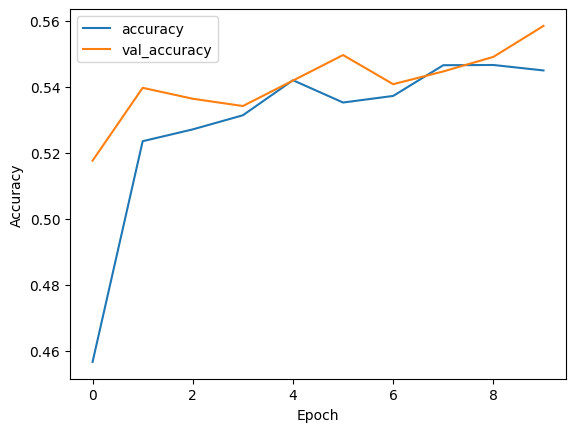

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0,1])
plt.legend()
plt.show()

# Sauvegarde du modèle

In [30]:
# Changer le nom du modèle si il s'agit d'un nouvel entrainement

# Save en dur
#nom_modele = '../model/gpot_v02_full_tri'

# Save sur GDrive
nom_modele =  '/content/drive/MyDrive/SAS/model/gpot_v02_full_tri'

In [31]:
model.save(nom_modele)